In [1]:
%matplotlib inline

import os
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

In [2]:
import desispec.io
import desisim.io
from desisim.obs import new_exposure
from desisim.scripts import quickgen
from desispec.scripts import group_spectra

/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def check_env():
    for env in ('DESIMODEL', 'DESI_ROOT', 'DESI_SPECTRO_SIM', 'DESI_SPECTRO_DATA', 
            'DESI_SPECTRO_REDUX', 'SPECPROD', 'PIXPROD'):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

In [5]:
check_env()

DESIMODEL environment set to /Users/ryanrubenzahl/Documents/DESI/code//desimodel
DESI_ROOT environment set to /Users/ryanrubenzahl/Documents/DESI
DESI_SPECTRO_SIM environment set to /Users/ryanrubenzahl/Documents/DESI/spectro/sim
DESI_SPECTRO_DATA environment set to /Users/ryanrubenzahl/Documents/DESI/spectro/data
DESI_SPECTRO_REDUX environment set to /Users/ryanrubenzahl/Documents/DESI/spectro/redux
SPECPROD environment set to dailytest
PIXPROD environment set to dailytest


In [6]:
%set_env SPECPROD=example
%set_env PIXPROD=example
rawdata_dir = desisim.io.simdir()
%set_env DESI_SPECTRO_DATA=$rawdata_dir

print('Simulated raw data will be written to {}'.format(desisim.io.simdir()))
print('Pipeline will read raw data from {}'.format(desispec.io.rawdata_root()))
print('    (without knowing that it was simulated)')
print('Pipeline will write processed data to {}'.format(desispec.io.specprod_root()))

env: SPECPROD=example
env: PIXPROD=example
env: DESI_SPECTRO_DATA=/Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/
Simulated raw data will be written to /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/
Pipeline will read raw data from /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/
    (without knowing that it was simulated)
Pipeline will write processed data to /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example


## Read in simulated spectra

In [7]:
flavor  = 'dark' # choose sky-brightness model and distribution of targets
flavors = ['dark', 'gray', 'grey', 'bright', 'bgs', 'mws', 'lrg', 'elg', 'qso', 'std', 'arc', 'flat'] # all options
night   = '20180201' # default is current date
expid   = 0 # exposure ID number, can use to simulate more than one DESI exposure

First get truth data of simulated objects

In [8]:
fiberfile   = desispec.io.findfile('fibermap', night=night, expid=expid)
simspecfile = desisim.io.findfile('simspec', night=night, expid=expid)

In [9]:
print('Reading simspec file {}.'.format(simspecfile))
hdu = fits.open(simspecfile)
hdu.info()
meta = Table(hdu['TRUTH'].data)
hdu.close()

Reading simspec file /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20180201/simspec-00000000.fits.
Filename: /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20180201/simspec-00000000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  WAVE          1 PrimaryHDU      58   (31900,)   float64   
  1  FLUX          1 ImageHDU         9   (31900, 1000)   float32   
  2  SKYFLUX       1 ImageHDU         9   (31900, 1000)   float32   
  3  WAVE_B        1 ImageHDU         7   (11896,)   float64   
  4  PHOT_B        1 ImageHDU         9   (11896, 1000)   float32   
  5  SKYPHOT_B     1 ImageHDU         9   (11896, 1000)   float32   
  6  WAVE_R        1 ImageHDU         7   (10575,)   float64   
  7  PHOT_R        1 ImageHDU         9   (10575, 1000)   float32   
  8  SKYPHOT_R     1 ImageHDU         9   (10575, 1000)   float32   
  9  WAVE_Z        1 ImageHDU         7   (11990,)   float64   
 10  PHOT_Z        1 ImageHDU         9   (11990, 1000)   floa

Now read in simulated spectra

In [10]:
nspec = len(meta)

In [11]:
cameras = ['b', 'r', 'z']
cframes = {camera: [] for camera in cameras}

In [12]:
cframefile = desispec.io.findfile('cframe', 
                                      night=night, 
                                      expid=expid, 
                                      camera='b0')

print cframefile
print desispec.io.frame.read_frame(cframefile)

/Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-b0-00000000.fits
<Frame: nspec=500, nwave=4760>


In [20]:
# From using desispec.io.frame.read_frame
for cam in cameras:
    for i in range(0, nspec, 500):
        camera = cam + "{}".format(i/500)
    
        cframefile = desispec.io.findfile('cframe', 
                                          night=night, 
                                          expid=expid, 
                                          camera=camera)
        print('Reading {}'.format(cframefile))
        cframes[cam] = desispec.io.frame.read_frame(cframefile)

Reading /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-b0-00000000.fits
Reading /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-b1-00000000.fits
Reading /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-r0-00000000.fits
Reading /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-r1-00000000.fits
Reading /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-z0-00000000.fits
Reading /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-z1-00000000.fits


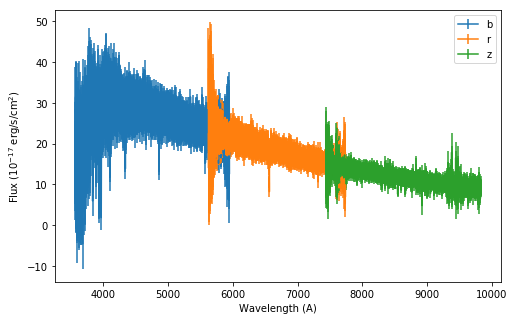

In [21]:
# Lets plot one of the spectra that we simulated
n = 41

fig, ax = plt.subplots(1,1, figsize=(8,5))
for camera in cameras:
    cframe = cframes[camera]

    ax.errorbar(cframe.wave, cframe.flux[n, :], 
                1/np.sqrt(cframe.ivar[n, :]), label=camera)
    ax.set_xlabel('Wavelength (A)')
    ax.set_ylabel('Flux ($10^{-17}$ erg/s/cm$^2$)')
ax.legend(loc='best')

## Spectral coaddition

Here we combine exposures from individual camera bands (b, r, z) into one exposure per camera, then combine the three cameras into one overall spectrum.

Overview on coaddition: https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=1056;filename=coadd.pdf;version=2

Test coaddition: `desispec/test/test_coadd.py`

Global coaddition: `desispec/scripts/updatecoadd.py`

In [22]:
from desispec.coaddition import Spectrum
from desispec.resolution import Resolution

### Wavelength Grids
see: https://github.com/desihub/desispec/blob/master/doc/coadd.rst


|  Band |	Min(A)|	Max(A) | Nbins | Size(A)  |	Files  |
|------- |-------- |------- |------- |-------- |--------| 
|b	    |  3579.0 |	5938.8 | 3934  | 0.6 |	brick, band coadd |
|r	    |  5635.0 |	7730.8 | 3494  | 0.6 |	brick, band coadd |
|z	    |  7445.0 |	9824.0 | 3966  | 0.6 |	brick, band coadd |
|all	|  3579.0 |	9825.0 | 6247  | 1.0 |	global coadd |

In [23]:
# Now combine the b, r, and z spectra into one final spectra

# First, get overall wavelength range of the spectrum
# Individual cameras have 0.5 A resolutions
# We make the final coadd spectrum uniformly spaced with 1.0 A
global_wavelength_grid = np.arange(cframes['b'].wave[0], 
                                   cframes['z'].wave[-1] + 0.5, 
                                   1.0, dtype=np.float32)

coadd_all_bands = Spectrum(global_wavelength_grid)
# coadd_all_spectra = Spectrum(desispec.coaddition.global_wavelength_grid)
for band in cframes:
    band_specobj = Spectrum(
                    cframes[band].wave,
                    flux=cframes[band].flux[n],
                    ivar=cframes[band].ivar[n],
                    resolution=Resolution(cframes[band].resolution_data[n]),
                    )
    
    coadd_all_bands += band_specobj

In [24]:
coadd_all_bands.finalize()

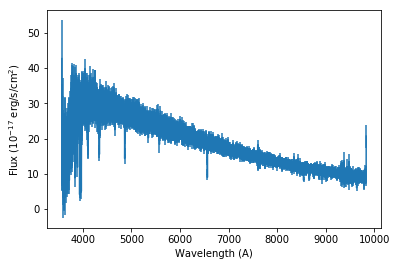

In [25]:
fig, ax = plt.subplots(1,1)

ax.errorbar(coadd_all_bands.wave, coadd_all_bands.flux, 1/np.sqrt(coadd_all_bands.ivar))
ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux ($10^{-17}$ erg/s/cm$^2$)')

In [139]:
from desispec.io.util import fitsheader

def write_coadd_spectra(outfile, coadd_spectra, fiberfile, simspecfile,
                        objtype=None, units=None):
    """
    Write the output of the full brz coadded spectra to a fits file.
    Include the truth and metadata from fiberfile and simspecfile
    """
    
    # Make parent directory if necessary
    dir, base = os.path.split(outfile)
    if not os.path.exists(dir):
        os.makedirs(dir)
        
    # Create HDUs from the data
    all_hdus = fits.HDUList()
    
    sshdu = fits.open(simspecfile)
    
    metadict = {'NIGHT': sshdu[0].header['NIGHT'],
                'EXPID': sshdu[0].header['EXPID'],
                'TILEID': sshdu[0].header['TILEID']}
    
    if not objtype == None:
        metadict['OBJTYPE'] = objtype
    
    # metadata goes in empty primary HD
    hdr = fitsheader(metadict)
    all_hdus.append(fits.PrimaryHDU(header=hdr))
    
    # Next is fibermap
    # Skip for now, since fiberfile contains fibermap data for
    # all 1000 (N) simulated spectra, will have to make this
    # input as a parameter that can be passed in
#     fmap = fits.open(fiberfile)['FIBERMAP']
#     hdu = fmap.header
    

    # Add the spectra data
    
    # Wavelength data
    hdu = fits.ImageHDU(name='WAVE')
    hdu.header["BUNIT"] = "Angstrom"
    hdu.data = coadd_spectra.wave.astype("f8")
    all_hdus.append(hdu)
    
    # Flux data
    hdu = fits.ImageHDU(name='FLUX')
    if units is None:
        hdu.header["BUNIT"] = "1e-17 erg/(s cm2 Angstrom)"
    else:
        hdu.header["BUNIT"] = units
    hdu.data = coadd_spectra.flux.astype("f4")
    all_hdus.append(hdu)
    
    # Variance data
    hdu = fits.ImageHDU(name="IVAR")
    hdu.data = coadd_spectra.ivar.astype("f4")
    all_hdus.append(hdu)
    
    # Mask
    if coadd_spectra.mask is not None:
        hdu = fits.CompImageHDU(name="MASK")
        hdu.data = coadd_spectra.mask.astype(np.uint32)
        all_hdus.append(hdu)
        
    # Resolution data
    if False:#coadd_spectra.resolution is not None:
        hdu = fits.ImageHDU(name="RESOLUTION")
        hdu.data = coadd_spectra.resolution.astype("f4")
        all_hdus.append(hdu)
        
    try:
        all_hdus.writeto("{}.tmp".format(outfile), 
                         overwrite=True, checksum=True)
    except TypeError:
        all_hdus.writeto("{}.tmp".format(outfile), 
                         clobber=True, checksum=True)
    os.rename("{}.tmp".format(outfile), outfile)
    
    return outfile

In [140]:
write_coadd_spectra("./output/test.fits", coadd_all_spectra, 
                    fiberfile, simspecfile)

'./output/test.fits'

In [32]:
print('Reading fibermap file {}.'.format(fiberfile))
hdu = fits.open(fiberfile)
hdu.info()
fibermap = Table(hdu['FIBERMAP'].data)
hdu.close()

Reading fibermap file /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20180201/fibermap-00000000.fits.
Filename: /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20180201/fibermap-00000000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  FIBERMAP      1 BinTableHDU    113   1000R x 26C   [10A, 20A, 8A, K, K, K, K, 5E, 50A, J, K, J, J, J, J, E, D, D, D, D, D, D, D, D, E, E]   


In [34]:
fibermap[200]

OBJTYPE,TARGETCAT,BRICKNAME,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,MAG [5],FILTER [5],SPECTROID,POSITIONER,LOCATION,DEVICE_LOC,PETAL_LOC,FIBER,LAMBDAREF,RA_TARGET,DEC_TARGET,RA_OBS,DEC_OBS,X_TARGET,Y_TARGET,X_FVCOBS,Y_FVCOBS,Y_FVCERR,X_FVCERR
str10,str20,str8,int64,int64,int64,int64,float32,str10,int32,int64,int32,int32,int32,int32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32
SKY,,3349p210,7546038331267425943,4294967296,0,0,0.0 .. 0.0,..,0,216,216,216,0,200,5400.0,334.996993548,20.9162717806,334.996993548,20.9162717806,7.63080723575,-256.464995442,7.63080723575,-256.464995442,0.0,0.0
